In [53]:
import time
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

tf.disable_v2_behavior()

In [54]:
dataset_X = scipy.io.loadmat('./dataset/timeseries/Trace_data.mat')['data']
dataset_Y = scipy.io.loadmat('./dataset/timeseries/Trace_label.mat')['label'][0]

In [55]:
X, Y = [], []

class_1 = 1
class_2 = 4

for i in range(len(dataset_Y)):
  if dataset_Y[i] == class_1 or dataset_Y[i] == class_2:
    X.append(dataset_X[i][:200])
    Y.append(dataset_Y[i])

X = np.array(X)[:40]
Y = np.array(Y)[:40]

In [56]:
Y = np.where(Y == class_2, -1, 1)

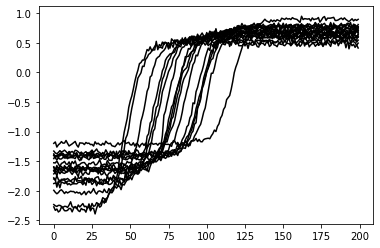

In [57]:
tmp = np.where(Y == -1)[0]
for i in range(len(tmp)):
  plt.plot(X[tmp[i]], 'k')
plt.show()

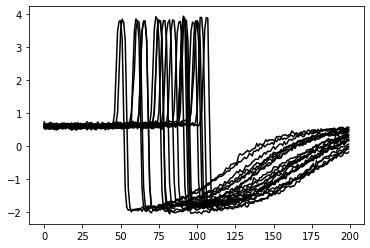

In [58]:
tmp = np.where(Y == 1)[0]
for i in range(len(tmp)):
  plt.plot(X[tmp[i]], 'k')

In [59]:
Y = np.array(Y).reshape(-1, 1)

In [60]:
train_cnt = 20

train_index = np.random.choice(len(X), size=train_cnt, replace=False)
test_index = [x for x in np.arange(0, len(X)) if x not in train_index]

train_X = X[train_index]
train_Y = Y[train_index]

test_X = X[test_index]
test_Y = Y[test_index]


print(train_index)
print(test_index)

[ 8  4  7 26 29 21 16 36 20 10 39 14 27  9 18 32 19  2 33 15]
[0, 1, 3, 5, 6, 11, 12, 13, 17, 22, 23, 24, 25, 28, 30, 31, 34, 35, 37, 38]


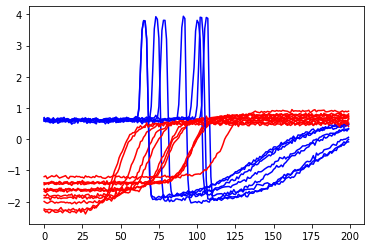

In [61]:
for i in range(len(train_X)):
  plt.plot(train_X[i].ravel(), 'b' if train_Y[i] == 1 else 'r')
plt.show()

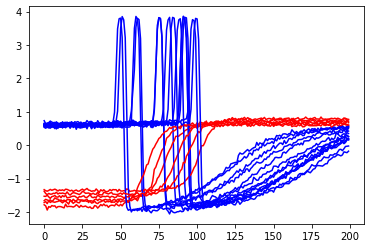

In [62]:
for i in range(len(test_X)):
  plt.plot(test_X[i].ravel(), 'b' if test_Y[i] == 1 else 'r')
plt.show()

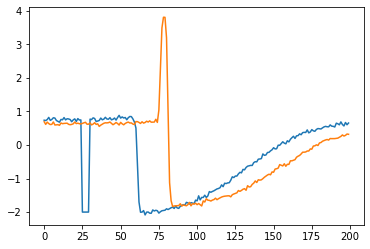

In [63]:
harmful_sample = dataset_X[3][:200]
harmful_sample[25:30] = -2.0
plt.plot(harmful_sample[:200])
plt.plot(train_X[0])
plt.show()

train_X[0] = harmful_sample

In [64]:
#BATCH_SIZE = int(np.shape(train_X)[0] / 2)
BATCH_SIZE = train_cnt
ITER = 5
LR = 0.01
GAMMA = 1.8

In [65]:
x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='train_X')
y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='train_Y')

b = tf.Variable(tf.random_uniform(shape=[1, BATCH_SIZE]))

pred_x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='prediction_X')

test_x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='test_X')
test_y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='test_Y')

In [66]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [67]:
gamma = tf.constant(GAMMA)
dtw_distances = tf.py_function(func=_dtw, inp=[x, x], Tout=[tf.float32 for i in range(BATCH_SIZE)])

kernel = tf.exp(-tf.multiply(gamma, dtw_distances))

In [68]:
first_term = tf.reduce_sum(b)

b_vec_cross = tf.matmul(tf.transpose(b), b)
train_Y_cross = tf.matmul(y, tf.transpose(y))
second_term = tf.reduce_sum(
    tf.multiply(kernel, tf.multiply(b_vec_cross, train_Y_cross))
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [69]:
# influence loss

In [70]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[x, pred_x], Tout=[tf.float32 for i in range(BATCH_SIZE)])
pred_kernel = tf.exp(-tf.multiply(gamma, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y)), tf.float32))

In [71]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[x, test_x], Tout=[tf.float32 for i in range(BATCH_SIZE)])
test_kernel = tf.exp(-tf.multiply(gamma, test_dtw_distances))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(y), b), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_y)), tf.float32))

In [72]:
optimizer = tf.train.GradientDescentOptimizer(LR)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

In [73]:
start = time.time()

loss_vec = []
batch_accuracy = []

for i in range(ITER):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(len(train_X), size=BATCH_SIZE, replace=False)
  rand_X = train_X[rand_index]
  rand_Y = train_Y[rand_index]

  sess.run(train, feed_dict={x: rand_X, y: rand_Y})
  temp_loss = sess.run(loss, feed_dict={x: rand_X, y: rand_Y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={x: rand_X, y: rand_Y, pred_x: rand_X})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
accuracy : 0.85
loss: -3.3735275
time : 53.23948812484741
Step #2
accuracy : 1.0
loss: -3.4382648
time : 53.91012096405029
Step #3
accuracy : 0.95
loss: -3.4996371
time : 53.535236835479736
Step #4
accuracy : 1.0
loss: -3.5594711
time : 53.36984586715698
Step #5
accuracy : 1.0
loss: -3.6164007
time : 52.901532888412476
Total time : 266.95702600479126


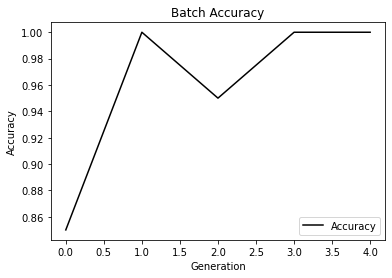

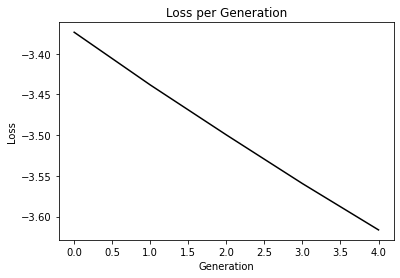

In [74]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [75]:
test_preds = sess.run(test_prediction,
                      feed_dict={
                          x: train_X,
                          y: train_Y,
                          test_x: test_X
                      })

In [76]:
test_preds = np.squeeze(test_preds)
_test_Y = np.squeeze(test_Y)

colors = []
cnt = 0
for i in range(len(test_preds)):
  if test_preds[i] == _test_Y[i]:
    cnt += 1
    colors.append('b')

  else:
    colors.append('r')

print(cnt)
print(cnt / len(test_preds))

16
0.8


In [77]:
z_grad_op = tf.gradients(loss, [b])
z_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y})
z_grad = np.squeeze(z_grad)

In [78]:
z_hess_op = tf.hessians(loss, [b])
z_hess = sess.run(z_hess_op, feed_dict={x: train_X, y: train_Y})
z_hess = np.squeeze(z_hess)

In [79]:
z_inv_hess = np.linalg.inv(z_hess)

In [80]:
# z_hess_grad = np.dot(z_hess, z_grad)
# np.shape(z_hess_grad)

In [81]:
# loo_inf = np.multiply(z_grad, z_hess_grad)
# loo_inf = [(i, loo_inf[i]) for i in range(len(loo_inf))]
# loo_inf = sorted(loo_inf, key=lambda x: x[1])
#

In [82]:
# print(loo_inf)

In [83]:
# for i in range(len(loo_inf)):
#   idx = int(loo_inf[i][0])
#   color = 'k'
#   if i < 5:
#     color = 'r'
#   elif i > 14:
#     color = 'b'
#
#   plt.plot(train_X[idx], color)
#
# plt.show()
#
#

In [84]:
# abs_loo_inf = np.absolute(loo_inf)
# abs_loo_inf = sorted(abs_loo_inf, key=lambda x: x[1])
#
# for i in range(len(abs_loo_inf)):
#   idx = int(abs_loo_inf[i][0])
#   plt.plot(train_X[idx], 'b' if i > 14 else 'k')
#
# plt.show()

In [85]:
inf_target_x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='train_X')

gamma = tf.constant(GAMMA)
inf_dtw_distances = tf.py_function(func=_dtw, inp=[x, inf_target_x], Tout=[tf.float32 for i in range(BATCH_SIZE)])

inf_kernel = tf.exp(-tf.multiply(gamma, inf_dtw_distances))

In [86]:
inf_first_term = tf.reduce_sum(b)

inf_b_vec_cross = tf.matmul(tf.transpose(b), b)
inf_train_Y_cross = tf.matmul(y, tf.transpose(y))
inf_second_term = tf.reduce_sum(
    tf.multiply(inf_kernel, tf.multiply(inf_b_vec_cross, inf_train_Y_cross))
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))

In [87]:
z_inf_target_grad_op = tf.gradients(inf_loss, [b])

loo_inf = []
for i in range(np.shape(train_X)[0]):
  z_inf_target_grad = sess.run(z_inf_target_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_inf_target_grad = np.squeeze(z_inf_target_grad)
  z_hess_grad = np.matmul(z_inv_hess, z_grad)
  inf_values = -np.matmul(z_inf_target_grad, z_hess_grad)
  loo_inf.append((i, inf_values))

In [88]:
loo_inf = sorted(loo_inf, key=lambda x: x[1])

In [89]:
print(loo_inf)

[(13, -2.8497992), (9, -2.7697897), (10, -2.5548222), (0, -2.1975925), (18, -2.193521), (4, -2.1318867), (8, -2.0897112), (5, -1.8310847), (15, -1.8018625), (2, -1.6799551), (12, -1.6382251), (14, -1.6199077), (16, -1.5368716), (11, -1.3200027), (3, -1.2155038), (6, -1.1447846), (1, -0.9883649), (17, -0.92738545), (19, -0.84715897), (7, -0.8426904)]


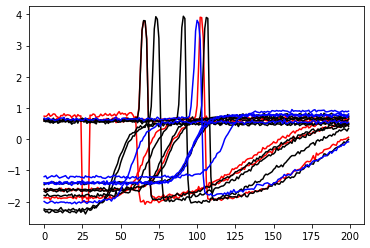

In [90]:
for i in range(len(loo_inf)):
  idx = int(loo_inf[i][0])
  color = 'k'
  if i < 5:
    color = 'r'
  elif i > 14:
    color = 'b'

  plt.plot(train_X[idx], color)

plt.show()

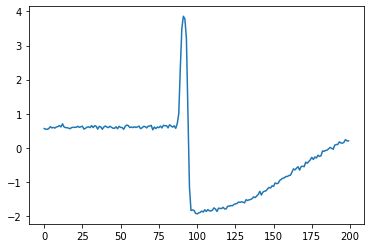

In [91]:
plt.plot(test_X[0])
plt.show()

In [122]:
z_test_grad = sess.run(z_inf_target_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [test_X[0]]})
#a = np.matmul(z_inv_hess, z_grad)
#b = -np.matmul(z_test_inf, a)

loo_inf = []

for i in range(np.shape(train_X)[0]):
  z_train_grad = sess.run(z_inf_target_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)
  z_hess_grad = np.matmul(z_inv_hess, z_train_grad)
  inf_values = np.matmul(z_test_grad, z_hess_grad)
  loo_inf.append((i, inf_values))

In [123]:
loo_inf = sorted(loo_inf, key=lambda x: x[1])

print(loo_inf)

[(13, array([[6.9966593]], dtype=float32)), (9, array([[7.063132]], dtype=float32)), (8, array([[7.6287293]], dtype=float32)), (15, array([[7.868064]], dtype=float32)), (2, array([[7.9694996]], dtype=float32)), (14, array([[8.019448]], dtype=float32)), (16, array([[8.088507]], dtype=float32)), (11, array([[8.268944]], dtype=float32)), (6, array([[8.414534]], dtype=float32)), (17, array([[8.59538]], dtype=float32)), (19, array([[8.662117]], dtype=float32)), (7, array([[8.665833]], dtype=float32)), (10, array([[11.273779]], dtype=float32)), (0, array([[11.570854]], dtype=float32)), (18, array([[11.574247]], dtype=float32)), (4, array([[11.625498]], dtype=float32)), (5, array([[11.8756695]], dtype=float32)), (12, array([[12.036061]], dtype=float32)), (3, array([[12.387606]], dtype=float32)), (1, array([[12.576528]], dtype=float32))]


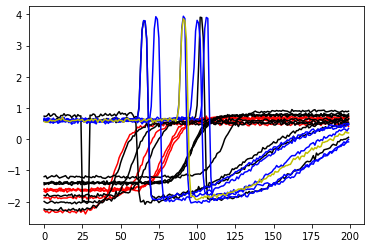

In [124]:
for i in range(len(loo_inf)):
  idx = int(loo_inf[i][0])
  color = 'k'
  if i < 5:
    color = 'r'
  elif i > 14:
    color = 'b'

  plt.plot(train_X[idx], color)

plt.plot(test_X[0], 'y')
plt.show()